In [1]:
%%capture out
!pip install torchmetrics pytorch_lightning -U
!pip install albucore==0.0.16 
!pip install segmentation_models_pytorch

In [4]:
import os
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from pathlib import Path
import time
from IPython.display import FileLink
from collections import OrderedDict
import random
import pandas as pd
import segmentation_models_pytorch as smp
from torch.optim import lr_scheduler
import shutil
from distutils.dir_util import copy_tree

import warnings
warnings.filterwarnings("ignore")

In [5]:
%%capture out

# the original dataset was downloaded by parts. Let's assemble it
source_1 = '/kaggle/input/imgs-train-rest/train_rest/'
source_2 = '/kaggle/input/imgs-val-rest/val_rest/'
source_3 = '/kaggle/input/satellites-masks/mask/'
source_4 = '/kaggle/input/satellites/Final_dataset/'

DEST = '/kaggle/working/data/'

if os.path.exists(DEST):
    shutil.rmtree(DEST)

shutil.copytree(source_4, DEST) 
copy_tree(source_1, DEST + 'images/train/')
copy_tree(source_2, DEST + 'images/val/')
copy_tree(source_3, DEST + 'mask/')

In [6]:
# Directory setting
IMAGES = '/kaggle/working/data/images/'
MASKS = '/kaggle/working/data/mask/'
OUT = '/kaggle/working/'

SEED = 33

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(f'Using {device} device')

CHECK_INTERSECT = True
CHECK_EXT = True
CHECK_MASKS = True
TRAIN_1 = True
TRAIN_2 = True
INFER_1 = True
INFER_2 = True

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 8
EPOCHS = 10
LR = 0.0001
T_MAX = 10#EPOCHS * len(train_dataset)/BATCH_SIZE
# Threshold for mask prediction
THRESHOLD = 0.7

Using cuda device


In [9]:
def seed_everything(seed):
    """Set seeds"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Set seed
seed_everything(SEED)


def load_img(path):
    """Loading image"""
    img_bgr = cv2.imread(path)
    #print(img_bgr.shape)
    #img_rgb = img_bgr[:, :, ::-1]
    img_rgb = np.flip(img_bgr,2)
    return img_rgb


def load_mask(path):
    """Loading mask in 3 formats: rgb, bin, 1hot"""
    #mask_name = Path(str(img_name).replace(".", "_mask.").replace("images", "mask"))
    colormap = [[0,0,0], [255,0,0], [0,255,0], [0,0,255]]
    #classes = ['background', 'solar_panel', 'body', 'antenna']
    mask_1hot = []
   
    try:
        mask = cv2.imread(path)
        #mask_rgb = mask[:, :, ::-1]
        mask_rgb = np.flip(mask,2)
        #mask_rgb = cv2.resize(mask[:, :, ::-1], (512,512))
        mask_bin = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2GRAY)
        mask_bin = np.where(mask_bin>0, 1, 0)
        mask_bin = np.expand_dims(mask_bin, axis=2)
        
        for i, color in enumerate(colormap):
            cmap = np.all(np.equal(mask_rgb, color), axis=2)#*i
            mask_1hot.append(cmap)
    except:
        return None
    
    mask_1hot = np.stack(mask_1hot, axis=-1).astype('int')#.sum(axis=-1)
    #mask_1hot = np.expand_dims(mask_1hot, -1)
    #print(mask_rgb.shape,mask_rgb)
    #mask_gs = np.argmax(mask_1hot, axis=-1)
    #mask_gs = (mask_gs / len(classes)) * 255
    #mask_gs = np.expand_dims(mask_gs, axis=-1)
    #print(mask_rgb.shape, mask_bin.shape, mask_1hot.shape)
    return [mask_rgb, mask_bin, mask_1hot]


def create_gallery(array, ncols=4):
    """Display multiple images in a gallery style.
    """    
    h,w = array[0].shape[0], array[0].shape[1]
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows * ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
        .swapaxes(1,2)
        .reshape(height*nrows, width*ncols, intensity))
    
    for hor_pad in range(result.shape[0]//h):
        result[h*hor_pad,:,:] = 255
    for ver_pad in range(result.shape[1]//w):
        result[:,w*ver_pad,:] = 255

    return result


def display_few_examples_from_data(dataset, n=4):
    """ Visualize samples with original and transformed masks"""
    figure, ax = plt.subplots(nrows=n, ncols=7, figsize=(15, n*2))
    for i,m in enumerate(np.random.choice(len(dataset),n,replace=False)): 
        image, mask,paths = dataset.__getitem__(m)
        ax[i, 0].imshow(load_img(paths[0]).squeeze())
        ax[i, 1].imshow(load_img(paths[1]).squeeze())
        ax[i, 2].imshow(image.clone().cpu().numpy().transpose((1,2,0)).astype(np.uint8))
        ax[i, 3].imshow(torch.permute(mask, (1,2,0))[:,:,1:] * 255)
        ax[i, 4].imshow(torch.permute(mask, (1,2,0))[..., 1].squeeze())
        ax[i, 5].imshow(torch.permute(mask, (1,2,0))[..., 2].squeeze())
        ax[i, 6].imshow(torch.permute(mask, (1,2,0))[..., 3].squeeze())
        ax[i, 0].set_title(f"Image_orig: {paths[0].split('/')[-1].split('_')[-1]}")
        ax[i, 1].set_title("Mask_orig")
        ax[i, 2].set_title("Image_transf")
        ax[i, 3].set_title("Mask_transf")
        ax[i, 4].set_title("Mask_solar_pan")
        ax[i, 5].set_title("Mask_body")
        ax[i, 6].set_title("Mask_antenna")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
        ax[i, 3].set_axis_off()
        ax[i, 4].set_axis_off()
        ax[i, 5].set_axis_off()
        ax[i, 6].set_axis_off()
        
    plt.tight_layout()
    plt.show()

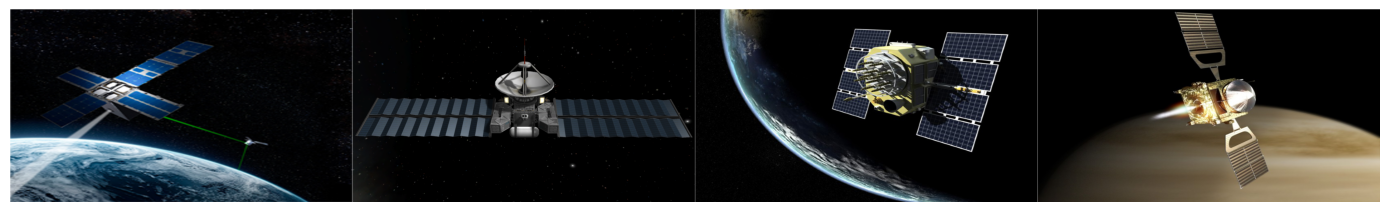

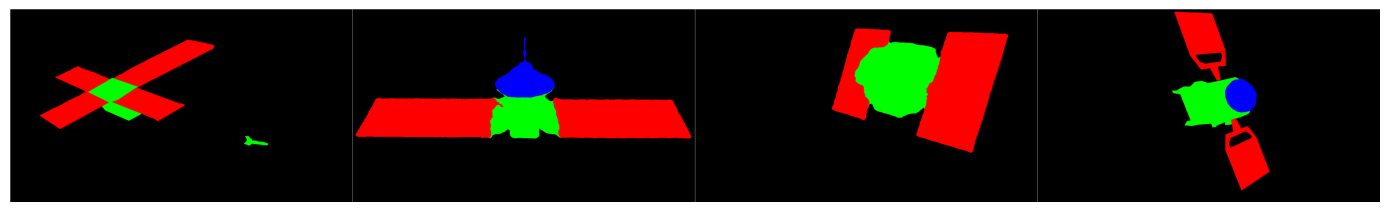

In [21]:
# some samples visualization
names = Path(IMAGES + 'train/').glob('*.png')
img_list, msk_list = [], []

for i, img_name in enumerate(names):
    mask_name = Path(str(img_name).replace(".", "_mask.").replace("images", "mask"))
    if os.path.exists(mask_name):
        img_list.append(load_img(img_name))
        msk_list.append(load_img(mask_name.as_posix()))
    if len(img_list) == 50: 
        break

for n in [img_list[36:40], msk_list[36:40]]:
    plt.figure(figsize=(14,10))
    plt.imshow(create_gallery(np.array(n), ncols=4));
    plt.axis('off');
    plt.tight_layout()
    plt.show()


In [22]:
# checking file extensions and image shapes
if CHECK_EXT:
    img_shape = set()
    img_ext = set()

    for path in [IMAGES, MASKS]:
        print(path.split('/')[-2])
        for folder in ['train/', 'val/']:
            print(f"   {folder}:", len(os.listdir(path+folder)))
            names = Path(path + folder).glob('*')
            pbar = tqdm(names, total=len(os.listdir(path + folder)))
            for img_name in pbar:
                img = load_img(img_name.as_posix())
                img_shape.add(img.shape)
                img_ext.add(img_name.suffix)

    print(f'Image shapes: {img_shape}.')
    print(f'Image extensions: {img_ext}.')

images
   train/: 2517


  0%|          | 0/2517 [00:00<?, ?it/s]

   val/: 600


  0%|          | 0/600 [00:00<?, ?it/s]

mask
   train/: 2517


  0%|          | 0/2517 [00:00<?, ?it/s]

   val/: 600


  0%|          | 0/600 [00:00<?, ?it/s]

Image shapes: {(720, 1280, 3)}.
Image extensions: {'.png'}.


In [23]:
# checking if all images have masks
if CHECK_MASKS:
    
    train_nomask = []
    val_nomask = []
    subsets = ['train/', 'val/']
    nomask_dict = dict((i,[]) for i in subsets)

    for i in subsets:
        for filename in os.listdir(IMAGES + i):
                mask_path = MASKS + i + filename.replace(".", "_mask.")
                if os.path.exists(mask_path)==False:
                    nomask_dict[i].append(filename)

    print(f"NO mask for {len(nomask_dict['train/'])} in TRAIN")
    print(f"NO mask for {len(nomask_dict['val/'])} in VAL")

NO mask for 0 in TRAIN
NO mask for 0 in VAL


In [24]:
class SatelDataset(Dataset):
    def __init__(self, split="train/", transform=None):
        self.images_filenames = os.listdir(IMAGES + split) 
        self.mask_filenames = os.listdir(MASKS + split)       
        self.transform = transform
        self.split = split

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image_path = IMAGES + self.split + image_filename
        mask_path = MASKS + self.split + image_filename.replace(".", "_mask.")

        if os.path.exists(mask_path)==False:
            
            return self.__getitem__(idx + 1 if (idx + 1) < self.__len__() else 0)
        else:
            image, mask = load_img(image_path), load_mask(mask_path)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask[2])
            #image.append(transformed["image"])
            #mask.append(transformed["mask"])
            image = transformed["image"]
            mask = transformed["mask"]

        return image, torch.permute(mask,(2,0,1)), [image_path, mask_path]

In [25]:
# define transformations
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Lambda(mask=round_clip_0_1),
        ToTensorV2(),
    ])


val_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
        ToTensorV2()
    ])

train_dataset = SatelDataset("train/", transform=train_transform)
val_dataset = SatelDataset("val/", transform=val_transform)
print(len(train_dataset), len(val_dataset))

2517 600


In [27]:
# checking if train and valid sets overlap
if CHECK_INTERSECT:
    train_names = [x[2][0].split('/')[-1] for x in train_dataset]
    val_names = [x[2][0].split('/')[-1] for x in val_dataset]
    print(f'NO intersection in subsets: {set(train_names).isdisjoint(set(val_names))}')

NO intersection in subsets: True



 =====Training dataset==========Training dataset==========Training dataset==========Training dataset==========Training dataset===== 



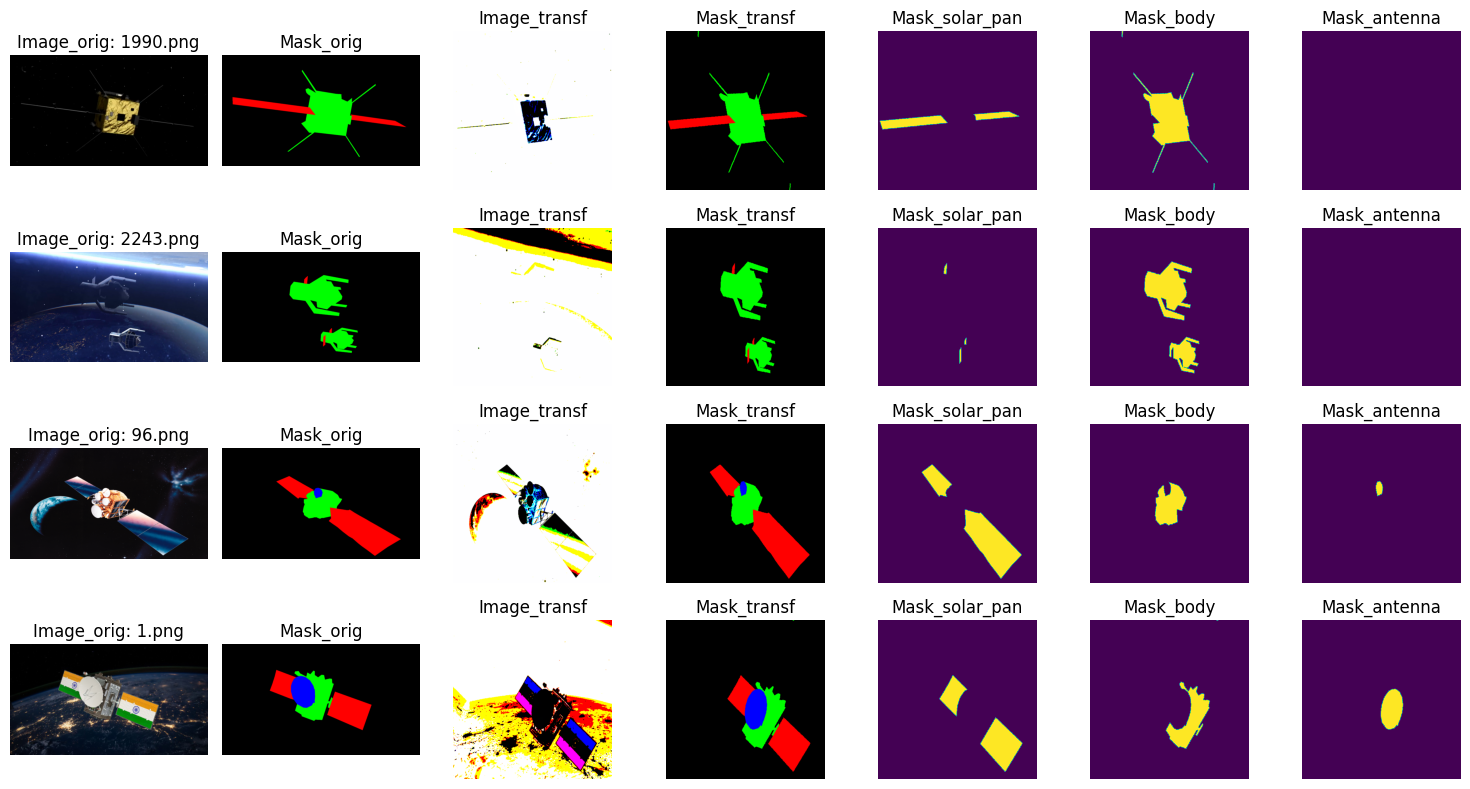


 =====Validation dataset==========Validation dataset==========Validation dataset==========Validation dataset==========Validation dataset===== 



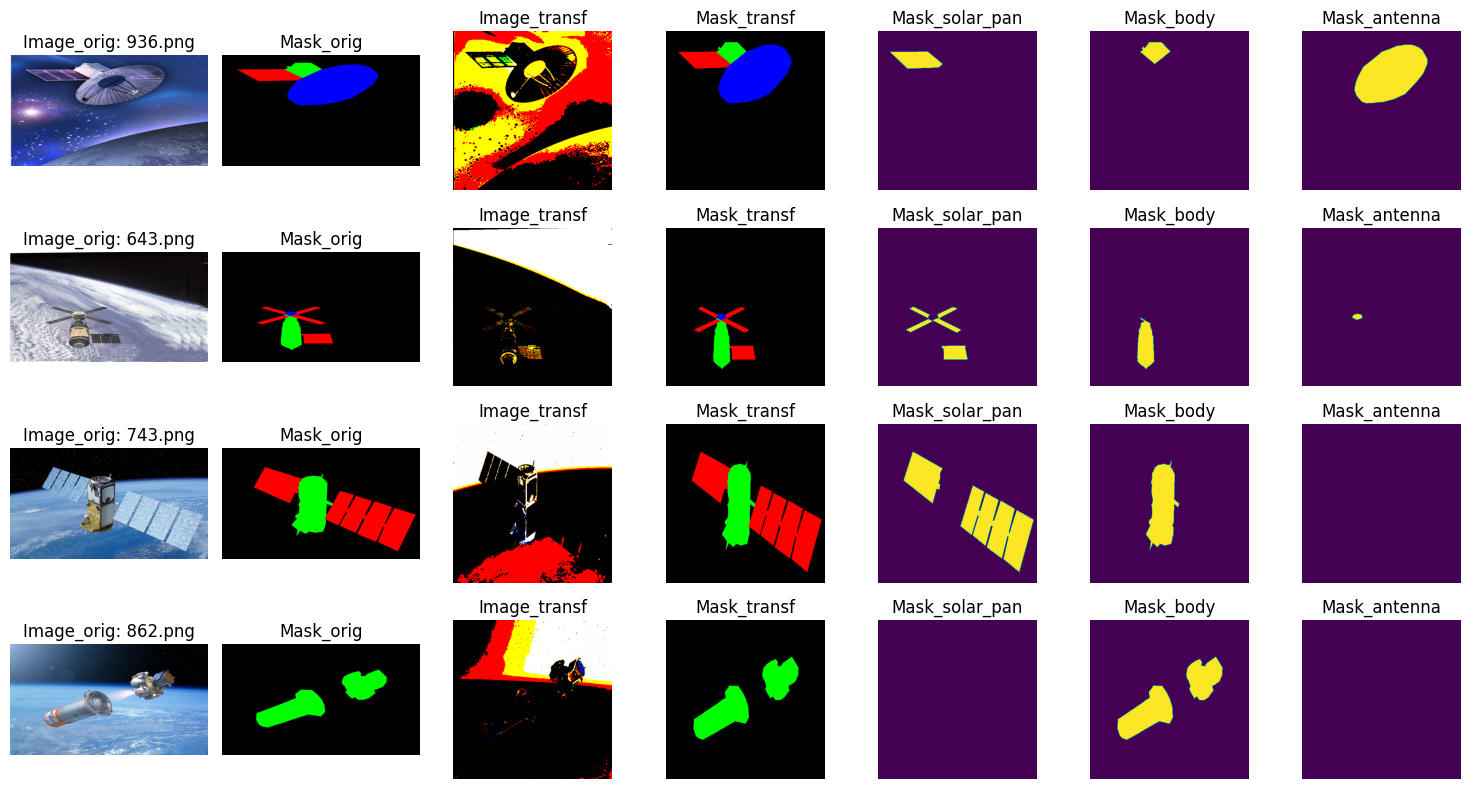

In [33]:
# datasets visualization
print('\n',"=====Training dataset====="*5, '\n')
display_few_examples_from_data(train_dataset)
print('\n', "=====Validation dataset====="*5, '\n')
display_few_examples_from_data(val_dataset)

# Case #1. 
## UNet from scratch. Baseline model

In [29]:
class DoubleConv(nn.Module):
    """DoubleConv is a basic building block of the encoder and decoder components. 
    Consists of two convolutional layers followed by a ReLU activation function.
    """    
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.double_conv(x)
        return x


class Down(nn.Module):
    """Downscaling.
    Consists of two consecutive DoubleConv blocks followed by a max pooling operation.
    """    
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x


class Up(nn.Module):
    """Upscaling.
    Performed using transposed convolution and concatenation of feature maps from the corresponding "Down" operation.
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input tensor shape: (batch_size, channels, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x
    

class UNet(nn.Module):
    """ Compose UNet """
    def __init__(self, n_channels=3, n_classes=4, bilinear=False):
        super(UNet, self).__init__()
        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        
        self.down4 = Down(512,1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = torch.softmax(x, dim=1)

        return x

In [30]:
class SegModel(pl.LightningModule):
    def __init__(self, train_dataset, val_dataset):
        super(SegModel, self).__init__()
        self.batch_size = BATCH_SIZE
        self.learning_rate = LR
        self.net = UNet()

        self.trainset = train_dataset
        self.valset = val_dataset
        #self.criterion = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTILABEL_MODE, from_logits=False)
        
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
        
    def forward(self, x):
        return self.net(x)

    def shared_step(self, batch, stage):
        image, mask, _ = batch
        image = image.to(device).float()
        mask = mask.to(device).float()

        # Shape of the image should be (batch_size, num_channels, height, width)
        assert image.ndim == 4
        # Check that image dimensions are divisible by 32,
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0
        #mask = batch["mask"]
        assert mask.ndim == 4
        # Check that mask values in between 0 and 1, NOT 0 and 255 
        assert mask.max() <= 1.0 and mask.min() >= 0

        prob_mask = self.forward(image)
        # Predicted mask contains probabilities, and loss_fn param `from_logits` is set to False
        loss = self.loss_fn(prob_mask, mask)
        pred_mask = (prob_mask > THRESHOLD).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="multilabel")
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_f1_score": f1_score,
        }

        self.log_dict(metrics, prog_bar=True)
    
    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LR)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "interval": "step", "frequency": 1,
            }
        }


In [31]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [46]:
if TRAIN_1: 
    start_time = time.time()

    model = SegModel(train_dataset, val_dataset)
    model.to(device)

    trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=valid_dataloader,
    )
    
    valid_metrics_unet = trainer.validate(model, dataloaders=valid_dataloader)
    
    time_unet = round((time.time() - start_time)/60, 2)
    print(f"Training time {round(time_unet,2)}")

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     valid_dataset_iou     │    0.8697021007537842     │
│      valid_f1_score       │     0.930310845375061     │
│    valid_per_image_iou    │    0.8752152919769287     │
└───────────────────────────┴───────────────────────────┘

Training time 60.12


### Model inference
Let's visualize some predictions of trained UNet. 

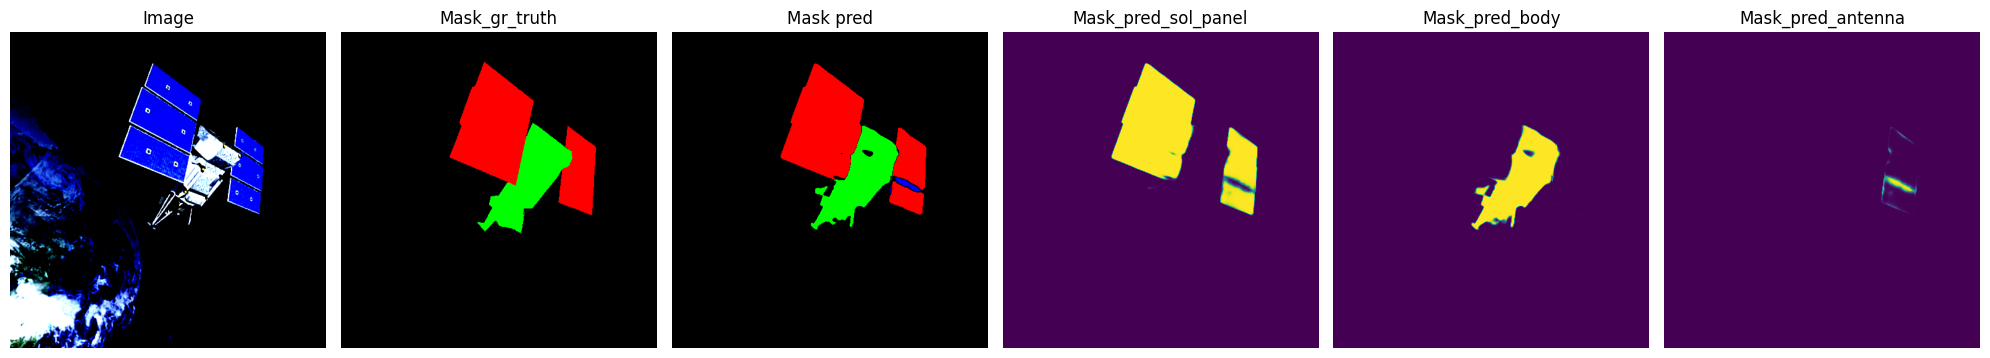

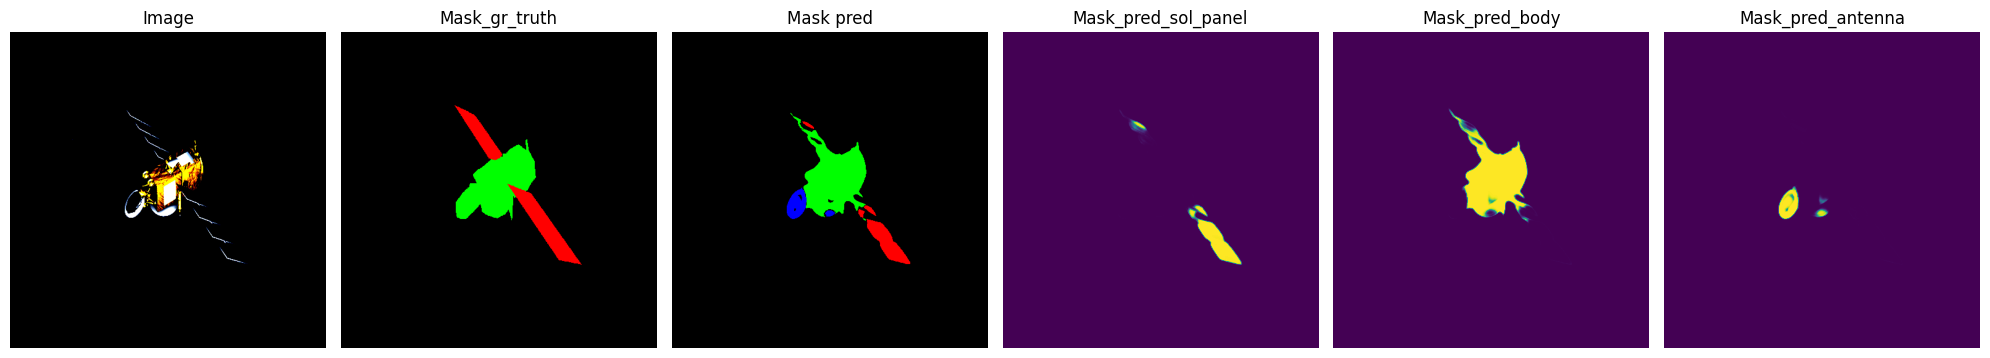

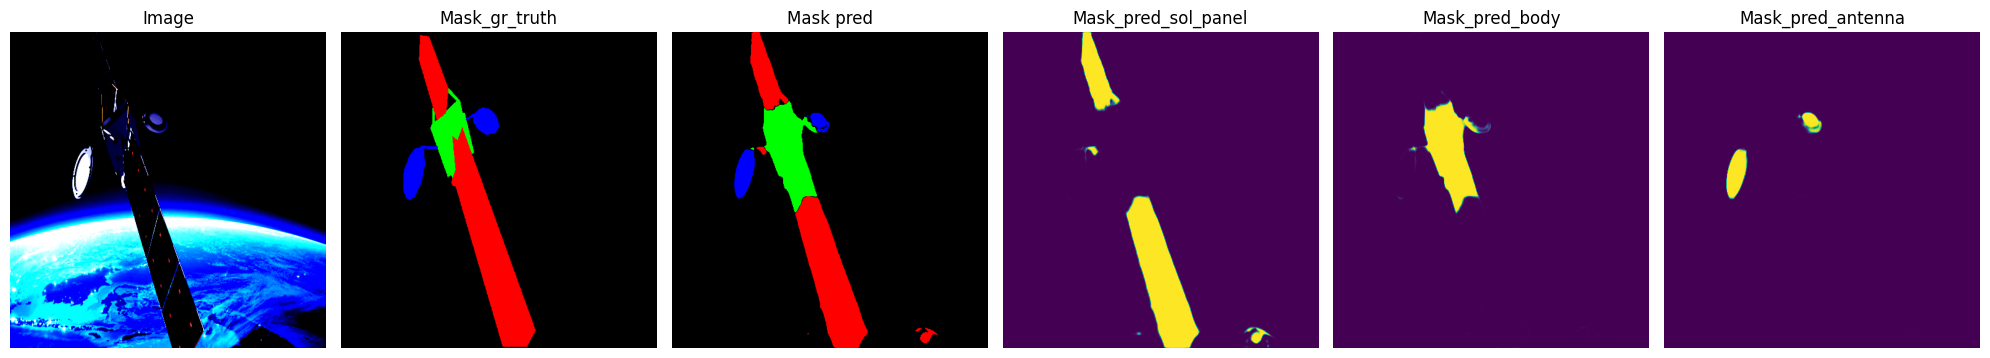

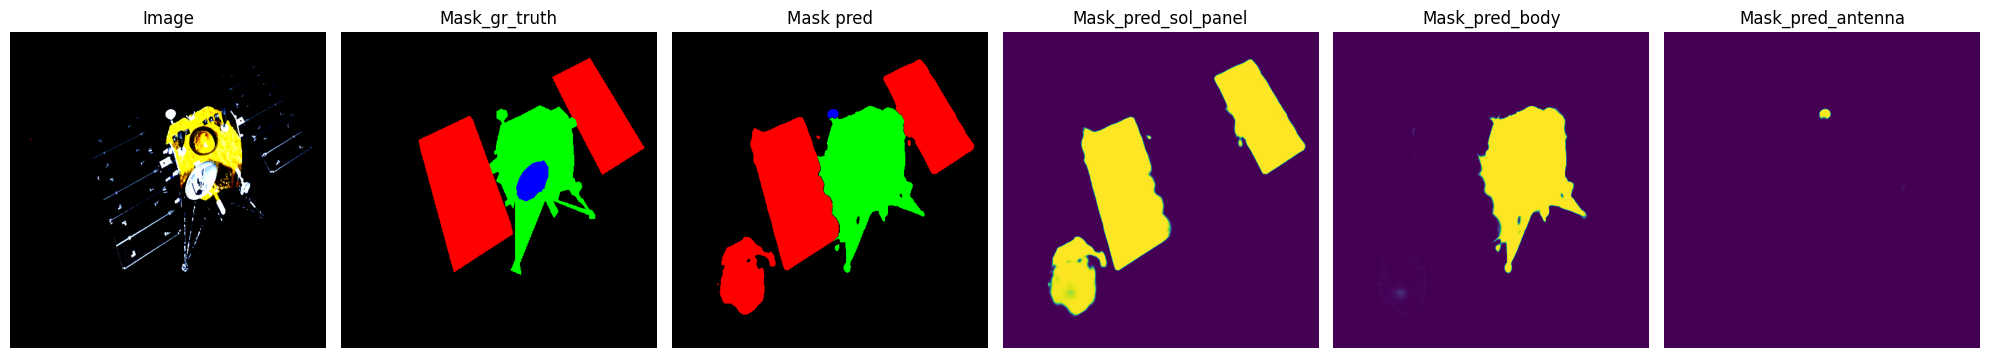

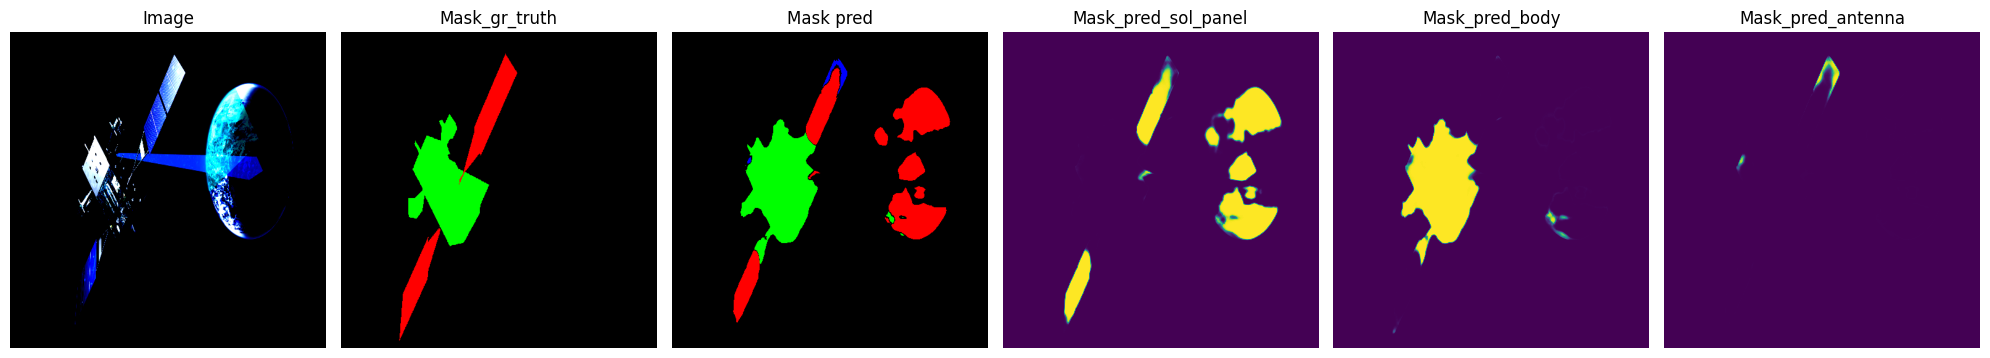

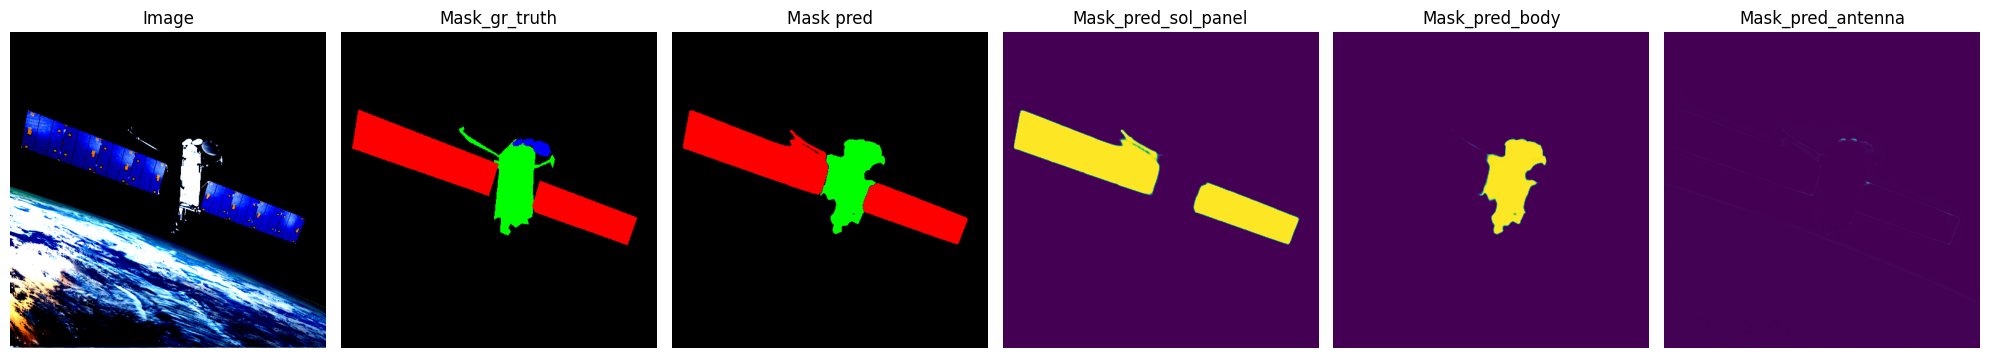

In [47]:
if INFER_1:
    batch_to_infer = iter(valid_dataloader)
    
    i = 0
    while i < 2:
        batch = next(batch_to_infer)
        i += 1
    
    with torch.no_grad():
        model.eval()
        logits_ = model(batch[0])

    for idx, (image, gt_mask, img_name, pr_mask) in enumerate(zip(batch[0], batch[1], batch[2][0], logits_)):
        #pr_mask = m(pr_mask)
        if idx in range(6):
            mask_pred = pr_mask.numpy().transpose(1,2,0)[:,:,1:]
            mask_pred = (mask_pred>THRESHOLD) * 255

            plt.figure(figsize=(20, 15))
    
            plt.subplot(1, 6, 1)
            plt.imshow(image.numpy().transpose(1, 2, 0))
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 6, 2)
            plt.imshow(gt_mask.numpy().transpose(1,2,0)[:,:,1:] * 255)
            plt.title("Mask_gr_truth")
            plt.axis("off")
        
            plt.subplot(1, 6, 3)
            plt.imshow(mask_pred)
            plt.title("Mask pred")
            plt.axis("off")

            for i, title in zip(range(1,4), ['Mask_pred_sol_panel', 'Mask_pred_body', 'Mask_pred_antenna']):
                plt.subplot(1, 6, 3+i)
                plt.imshow(pr_mask.numpy().transpose(1,2,0)[...,i].squeeze())
                plt.title(title)
                plt.axis("off")
    
        else:
            continue
 
        plt.tight_layout()
        plt.show()

In [ ]:
# saving model weights
#torch.save(model.state_dict(), '/kaggle/working/unet.pth')
#!zip -r /kaggle/working/unet_5.zip /kaggle/working/unet.pth
#os.chdir(OUT)
#FileLink(r'unet_5.zip')

#!ls /kaggle/working/

===============================================================================
# Case #2. 
## UNet w. EfficientNet-backbone pretrained on Imagenet-dataset


In [37]:
%%capture
!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
#!pip install lightning albumentations

In [38]:
# Some training hyperparameters
BACKBONE = 'efficientnet-b0'
CLASSES = ['background', 'solar_panel', 'body', 'antenna']

n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#preprocess_input = sm.get_preprocessing(BACKBONE)

In [39]:
class SatModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            encoder_weights='imagenet',
            in_channels=in_channels,
            classes=out_classes,
            activation=activation,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTILABEL_MODE, from_logits=False) 
        
        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        #image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask, _ = batch
        image = image.to(device).float()
        mask = mask.to(device).float()

        # Shape of the image should be (batch_size, num_channels, height, width)
        assert image.ndim == 4
        # Check that image dimensions are divisible by 32,
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0
        #mask = batch["mask"]
        assert mask.ndim == 4
        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        prob_mask = self.forward(image)
        # Predicted mask contains probabilities, and loss_fn param `from_logits` is set to False
        loss = self.loss_fn(prob_mask, mask)
        # Lets compute metrics for threshold
        pred_mask = (prob_mask > THRESHOLD).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="multilabel")
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_f1_score": f1_score,
        }
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LR)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [41]:
if TRAIN_2:
    start_time = time.time()
    model = SatModel("unet", BACKBONE, in_channels=3, out_classes=n_classes)
    #model = SatModel("FPN", "resnet34", in_channels=3, out_classes=1)
    #model = SatModel("deeplabv3plus", "mobilenet_v2", in_channels=3, out_classes=1)

    trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=valid_dataloader,
    )

    # run validation dataset
    valid_metrics_unet_eff = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
    print(valid_metrics_unet_eff)

    time_unet_eff = round((time.time() - start_time)/60,2)
    print(f"Training time {time_unet_eff}")

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_per_image_iou': 0.9435073137283325, 'valid_dataset_iou': 0.941649854183197, 'valid_f1_score': 0.9699481725692749}]
Training time 40.32


### Model inference.
Let's visualize some predictions of UNet w. EfficientNet-backbone pretrained on Imagenet-dataset.

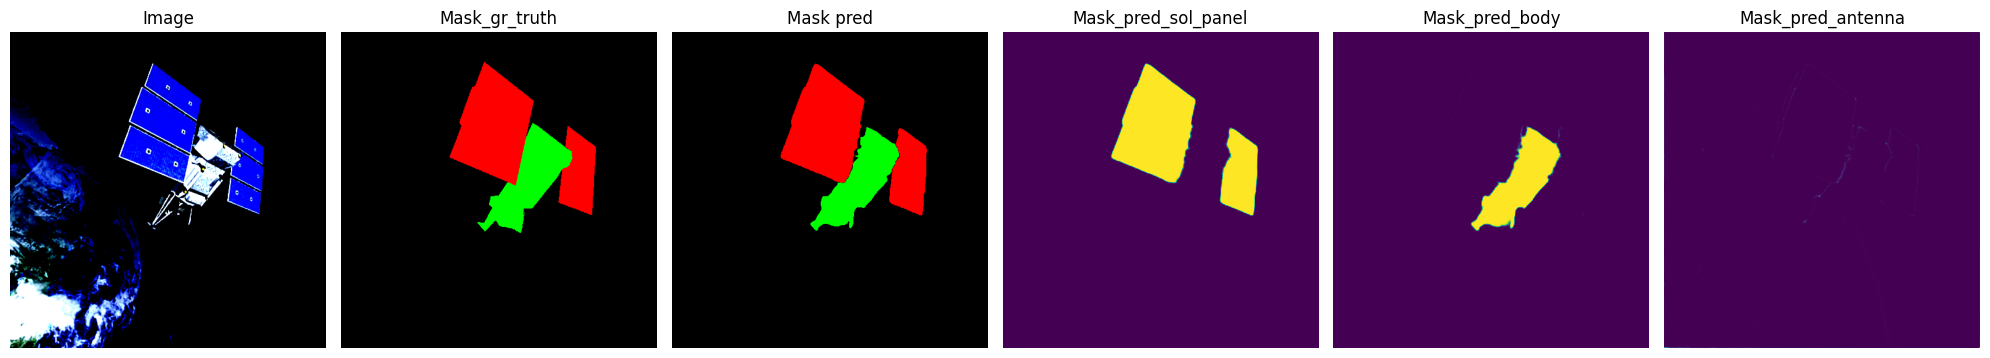

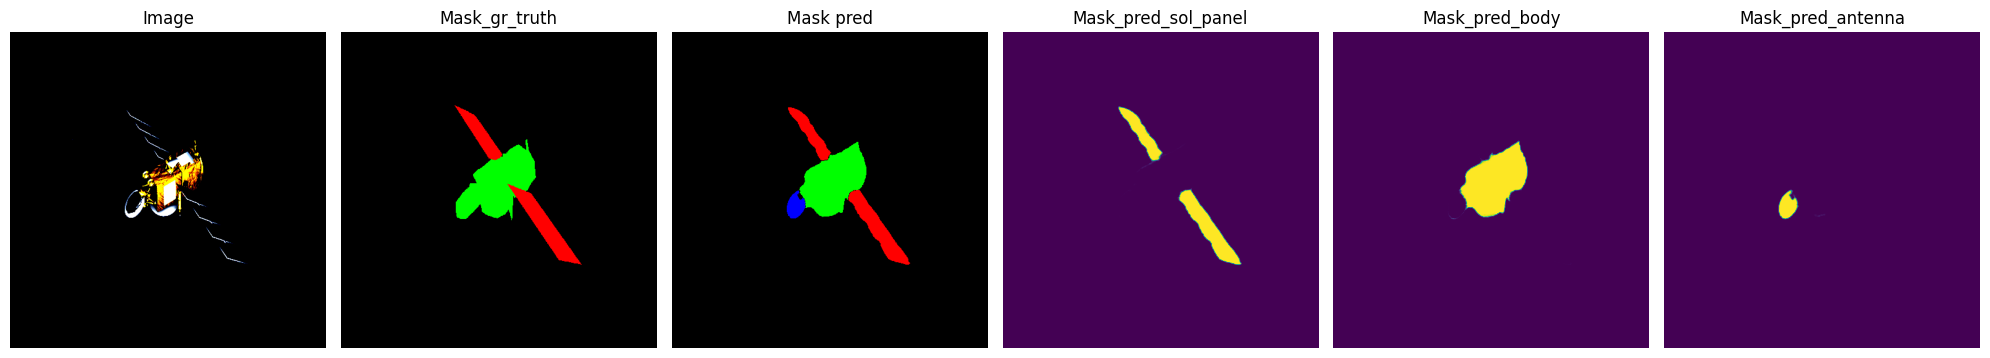

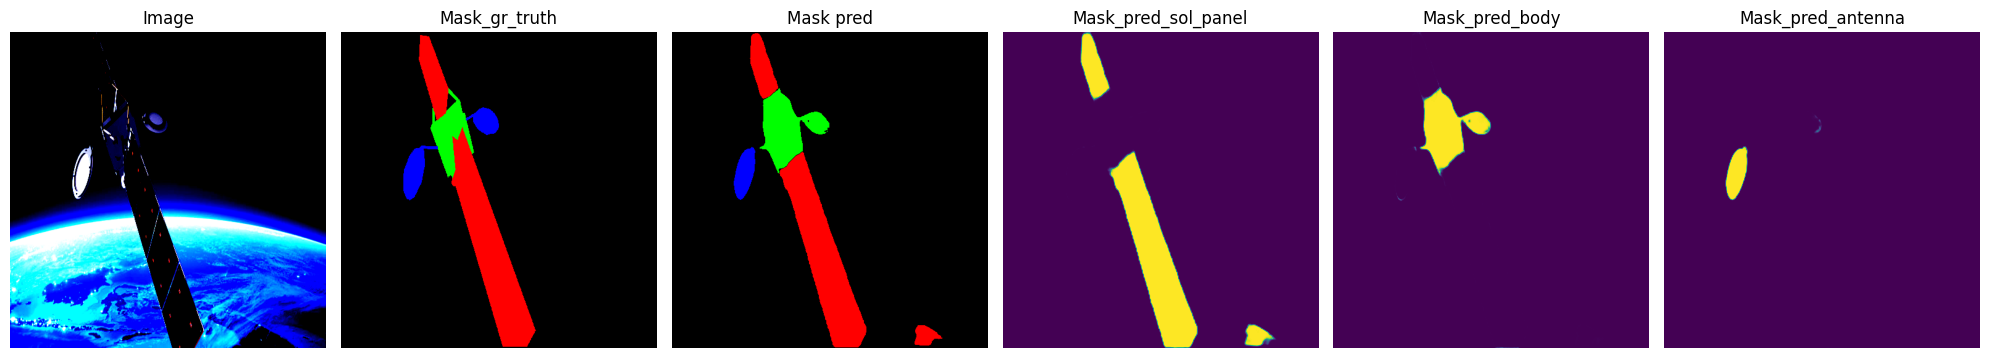

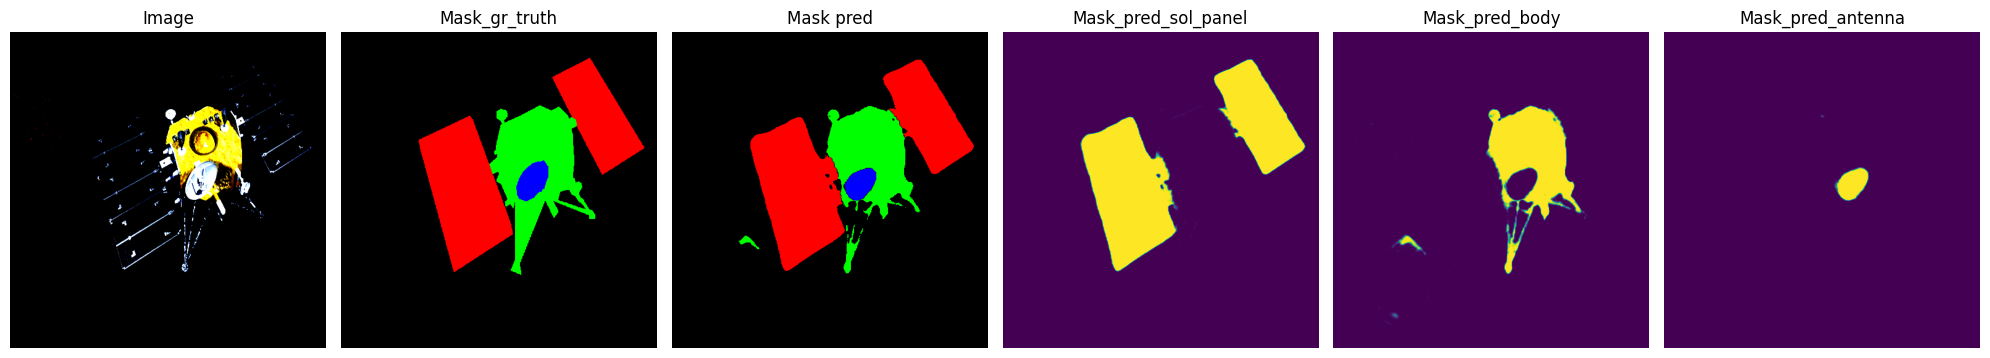

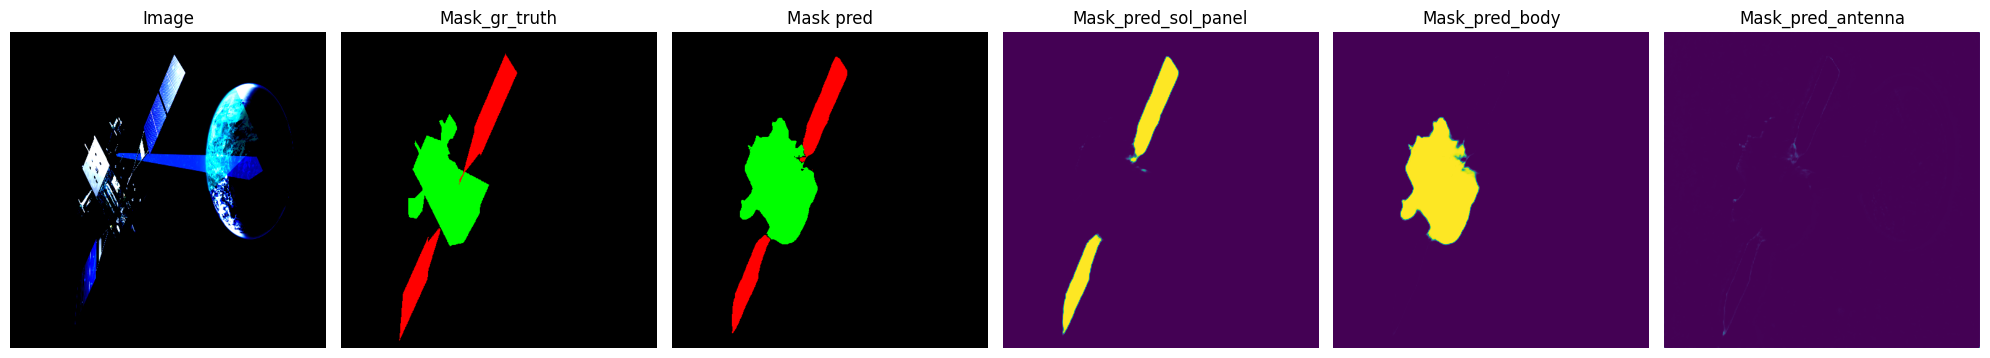

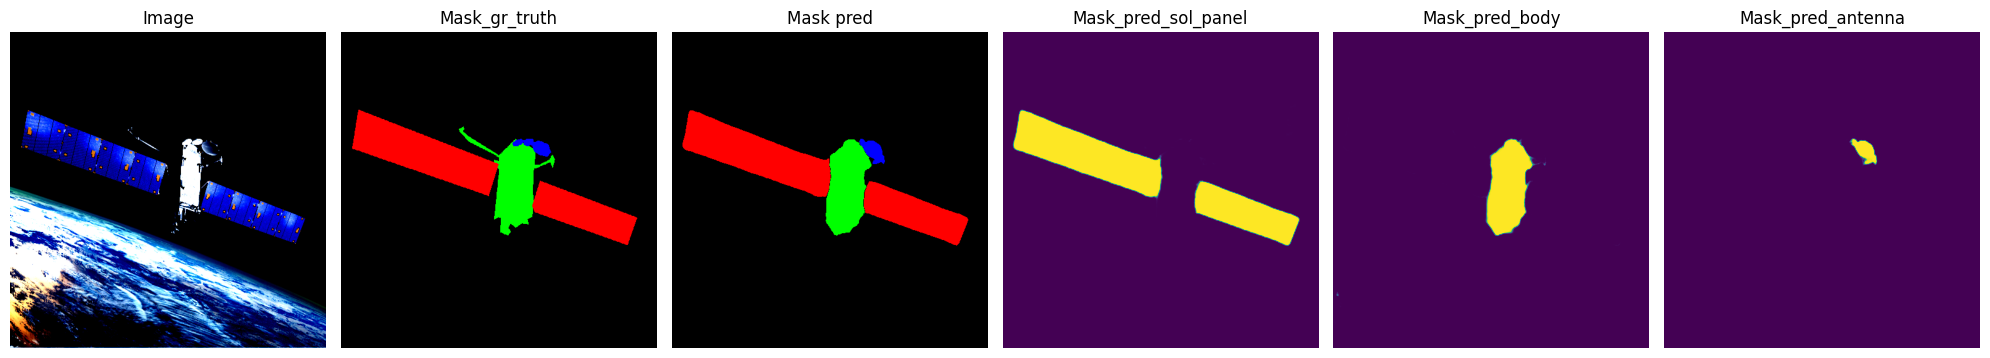

In [45]:
if INFER_2:
    batch_to_infer = iter(valid_dataloader)
    
    i = 0
    while i < 2:
        batch = next(batch_to_infer)
        i += 1
    
    with torch.no_grad():
        model.eval()
        logits = model(batch[0])

    for idx, (image, gt_mask, img_name, pr_mask) in enumerate(zip(batch[0], batch[1], batch[2][0], logits)):
        #pr_mask = m(pr_mask)
        if idx in range(6):
            mask_pred = pr_mask.numpy().transpose(1,2,0)[:,:,1:]
            mask_pred = (mask_pred>THRESHOLD) * 255

            plt.figure(figsize=(20, 15))
    
            plt.subplot(1, 6, 1)
            plt.imshow(image.numpy().transpose(1, 2, 0))
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 6, 2)
            plt.imshow(gt_mask.numpy().transpose(1,2,0)[:,:,1:] * 255)
            plt.title("Mask_gr_truth")
            plt.axis("off")
        
            plt.subplot(1, 6, 3)
            plt.imshow(mask_pred)
            plt.title("Mask pred")
            plt.axis("off")

            for i, title in zip(range(1,4), ['Mask_pred_sol_panel', 'Mask_pred_body', 'Mask_pred_antenna']):
                plt.subplot(1, 6, 3+i)
                plt.imshow(pr_mask.numpy().transpose(1,2,0)[...,i].squeeze())
                plt.title(title)
                plt.axis("off")
    
        else:
            continue
 
        plt.tight_layout()
        plt.show()

# Summary

In [52]:
summary = pd.DataFrame(
    [
    ['UNet', 
     time_unet, 
     valid_metrics_unet[0]['valid_dataset_iou'], 
     valid_metrics_unet[0]['valid_f1_score']], 
    ['UNet-efficNet', 
     time_unet_eff, 
     valid_metrics_unet_eff[0]['valid_dataset_iou'], 
     valid_metrics_unet_eff[0]['valid_f1_score']]
    ], 
    columns=['Model', 'Train_time, min', 'Valid_IoU', 'Valid_f1_score'],
    ).set_index(['Model'])

summary.style.set_properties(subset=summary.columns, **{'width': '130px', 'text-align': 'right'})

,"Train_time, min",Valid_IoU,Valid_f1_score
Model,,,
UNet,60.120000,0.869702,0.930311
UNet-efficNet,40.320000,0.941650,0.969948


Two models based on UNet were compared in satellites segmentation task.
As expected, UNet with EfficientNet-b0 backbone (4M, params; pretrained on Imagenet) significantly outperformed base UNet acccording to all criterias designated, after only 10 epochs training:
    
    * It works 1.5 times faster than the base model, on the same hardware configuration; 
    * it showed significantly better values ​​for all metrics;

How to improve results:

1) Scaling EfficientNet backbone to HW resource constraints
2) Increasing training epochs number
3) Another NN architecture + encoder combination should be tested too

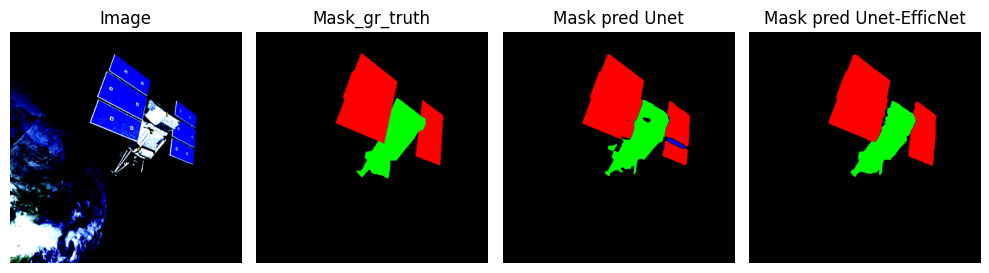

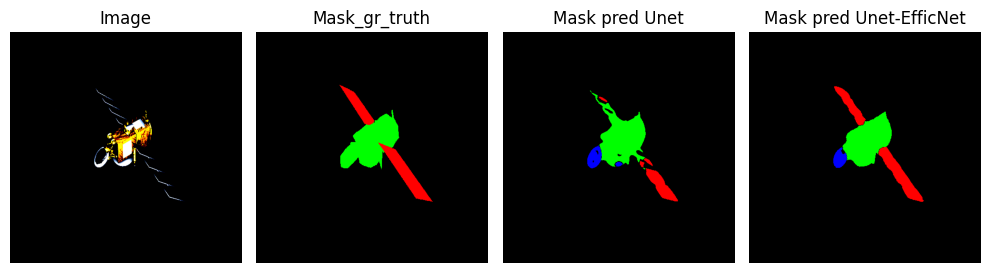

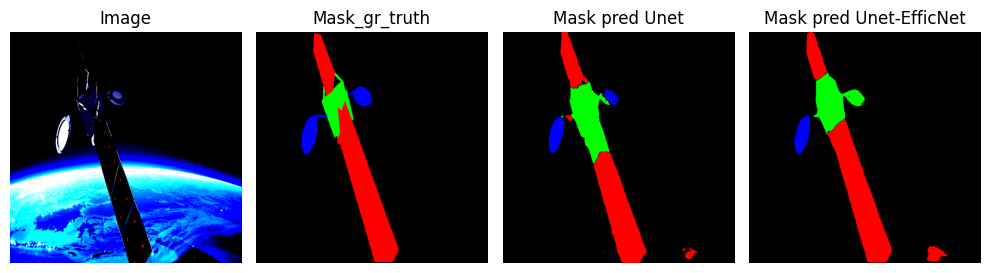

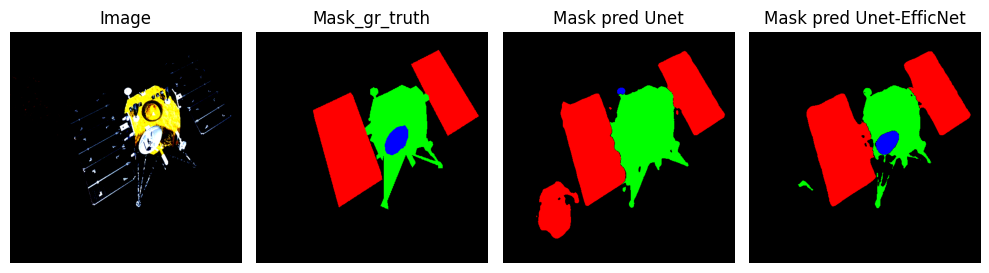

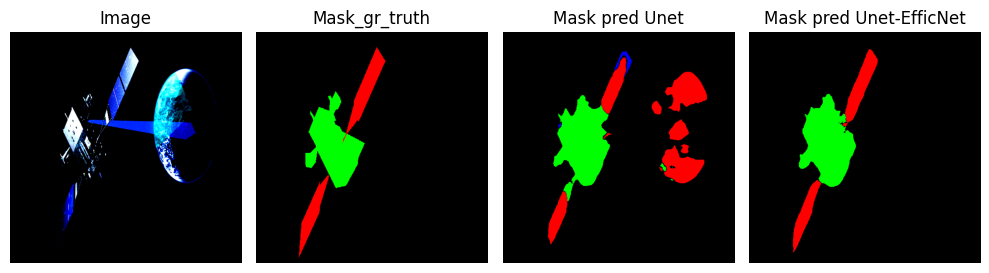

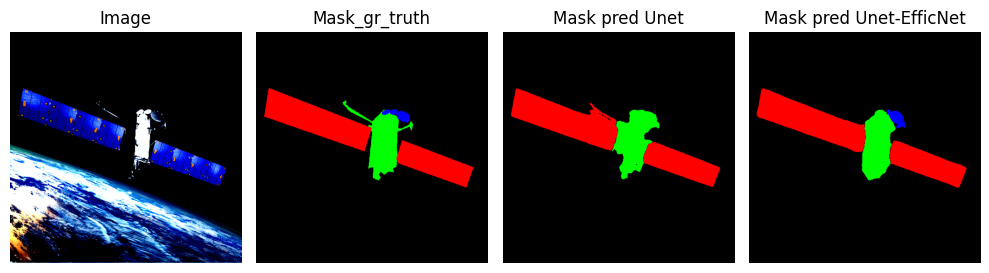

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [55]:
for idx, (image, gt_mask, img_name, pr_mask_, pr_mask) in enumerate(zip(batch[0], batch[1], batch[2][0], logits_, logits)):
        #pr_mask = m(pr_mask)
        plt.figure(figsize=(10, 10))
        if idx in range(6):
            mask_pred_ = pr_mask_.numpy().transpose(1,2,0)[:,:,1:]
            mask_pred_ = (mask_pred_>THRESHOLD) * 255
            mask_pred = pr_mask.numpy().transpose(1,2,0)[:,:,1:]
            mask_pred = (mask_pred>THRESHOLD) * 255

            plt.subplot(1, 4, 1)
            plt.imshow(image.numpy().transpose(1, 2, 0))
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 4, 2)
            plt.imshow(gt_mask.numpy().transpose(1,2,0)[:,:,1:] * 255)
            plt.title("Mask_gr_truth")
            plt.axis("off")
        
            plt.subplot(1, 4, 3)
            plt.imshow(mask_pred_)
            plt.title("Mask pred Unet")
            plt.axis("off")
            
            plt.subplot(1, 4, 4)
            plt.imshow(mask_pred)
            plt.title("Mask pred Unet-EfficNet")
            plt.axis("off")
            
        plt.tight_layout()
        plt.show()